In [44]:
import pandas as pd
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

# Load the datasets
customers_df = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/customers_final.csv')
engagements_df = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/engagements_final.csv')
marketing_df = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/marketing_final.csv')
transactions_df = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/transactions_final.csv')

In [45]:
## DATA CLEANING

In [46]:
# Convert date columns to datetime
customers_df['join_date'] = pd.to_datetime(customers_df['join_date'])
customers_df['last_purchase_date'] = pd.to_datetime(customers_df['last_purchase_date'])
marketing_df['campaign_date'] = pd.to_datetime(marketing_df['campaign_date'])
transactions_df['transaction_date'] = pd.to_datetime(transactions_df['transaction_date'])

In [47]:
# Define the cutoff date
cutoff_date = pd.to_datetime('2024-05-31')

# Convert dates later than 5/31/2024 to 5/31/2024
customers_df['join_date'] = customers_df['join_date'].apply(lambda x: x if x <= cutoff_date else cutoff_date)
customers_df['last_purchase_date'] = customers_df['last_purchase_date'].apply(lambda x: x if x <= cutoff_date else cutoff_date)
marketing_df['campaign_date'] = marketing_df['campaign_date'].apply(lambda x: x if x <= cutoff_date else cutoff_date)
transactions_df['transaction_date'] = transactions_df['transaction_date'].apply(lambda x: x if x <= cutoff_date else cutoff_date)

In [48]:
# Aggregate marketing responses
marketing_agg = marketing_df.groupby('customer_id')['response'].value_counts().unstack(fill_value=0).reset_index()
marketing_agg.columns = ['customer_id', 'no_response', 'yes_response']

# Aggregate transaction data
transactions_agg = transactions_df.groupby('customer_id').agg(
    total_transaction_amount=pd.NamedAgg(column='transaction_amount', aggfunc='sum'),
    number_of_transactions=pd.NamedAgg(column='transaction_id', aggfunc='count')
).reset_index()

# Merge all dataframes
merged_df = customers_df.merge(engagements_df, on='customer_id', how='left') \
                        .merge(marketing_agg, on='customer_id', how='left') \
                        .merge(transactions_agg, on='customer_id', how='left')

# Fill NaN values for no_response and yes_response with 0
merged_df['no_response'] = merged_df['no_response'].fillna(0)
merged_df['yes_response'] = merged_df['yes_response'].fillna(0)

# Fill NaN values for total_transaction_amount and number_of_transactions with 0
merged_df['total_transaction_amount'] = merged_df['total_transaction_amount'].fillna(0)
merged_df['number_of_transactions'] = merged_df['number_of_transactions'].fillna(0)

In [49]:
# Impute 'Unknown' for missing gender values
merged_df['gender'] = merged_df['gender'].fillna('Unknown')

In [50]:
# Impute missing age with KNNImputer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder

# Convert date columns to numeric
merged_df['join_date_numeric'] = merged_df['join_date'].astype('int64') // 10**9
merged_df['last_purchase_date_numeric'] = merged_df['last_purchase_date'].astype('int64') // 10**9

# Encode categorical variables
le_gender = LabelEncoder()
merged_df['gender_encoded'] = le_gender.fit_transform(merged_df['gender'])

le_location = LabelEncoder()
merged_df['location_encoded'] = le_location.fit_transform(merged_df['location'])

# Prepare data for KNN imputation
impute_cols = ['age', 'join_date_numeric', 'last_purchase_date_numeric', 'gender_encoded', 'location_encoded']
impute_data = merged_df[impute_cols]

# Perform KNN imputation
knn_imputer = KNNImputer(n_neighbors=5)
imputed_data = knn_imputer.fit_transform(impute_data)

# Assign imputed age values back to the dataframe
merged_df['age'] = imputed_data[:, 0]

# Drop intermediate columns
merged_df = merged_df.drop(columns=['join_date_numeric', 'last_purchase_date_numeric', 'gender_encoded', 'location_encoded'])

In [51]:
## Feature Engineering

In [52]:
# Calculate Recency, Frequency, and Monetary (clv_monthly) Value (RFM) features
import numpy as np

# Define the cutoff date
cutoff_date = pd.to_datetime('2024-06-01')

# Calculate the joined month
merged_df['joined_month'] = ((cutoff_date - merged_df['join_date']).dt.days / 30).astype(int)
merged_df['joined_month'] = merged_df['joined_month'].apply(lambda x: 1 if x == 0 else x)

# Calculate Recency (in months)
merged_df['recency_months'] = (( merged_df['last_purchase_date'] - cutoff_date).dt.days / 30).astype(int)

# Calculate Frequency
merged_df['frequency'] = merged_df['number_of_transactions']

# Calculate Monetary Value (transaction value per month, clv_monthly)
merged_df['clv_monthly'] = merged_df['total_transaction_amount'] / merged_df['joined_month']

# Fill any NaN values resulting from zero transactions or other calculations
merged_df['recency_months'] = merged_df['recency_months'].fillna(0)
merged_df['frequency'] = merged_df['frequency'].fillna(0)
merged_df['clv_monthly'] = merged_df['clv_monthly'].fillna(0)

In [53]:
# For marketing and engagement data
# Calculate the number of 'yes_response' per transaction
merged_df['yes_response_per_transaction'] = merged_df['yes_response'] / merged_df['number_of_transactions']

# Calculate the number of 'no_response' per transaction
merged_df['no_response_per_transaction'] = merged_df['no_response'] / merged_df['number_of_transactions']

# Calculate the number of site visits per transaction
merged_df['site_visits_per_transaction'] = merged_df['number_of_site_visits'] / merged_df['number_of_transactions']

# Calculate the number of emails opened per transaction
merged_df['emails_opened_per_transaction'] = merged_df['number_of_emails_opened'] / merged_df['number_of_transactions']

# Calculate the number of clicks per transaction
merged_df['clicks_per_transaction'] = merged_df['number_of_clicks'] / merged_df['number_of_transactions']

In [54]:
# use the 80-20 rule, sorting the customer with clv_monthly
# labelling the highest clv_monthly customers who cumulatively contribute 80% of the total monthly clv as 'High-Value'
# other as ‘Low-Value’

# Calculate the cumulative contribution of each customer to the total monthly CLV
merged_df = merged_df.sort_values(by='clv_monthly', ascending=False)
merged_df['cumulative_clv'] = merged_df['clv_monthly'].cumsum()
total_clv = merged_df['clv_monthly'].sum()
merged_df['cumulative_clv_percentage'] = merged_df['cumulative_clv'] / total_clv

# Label customers based on their contribution to the total monthly CLV
merged_df['value_label'] = np.where(merged_df['cumulative_clv_percentage'] <= 0.80, 'High-Value', 'Low-Value')

# Convert CLV_label to binary
merged_df['value_label'] = np.where(merged_df['value_label'] == 'High-Value', 1, 0)

# Drop intermediate columns
merged_df = merged_df.drop(columns=['cumulative_clv', 'cumulative_clv_percentage'])

In [55]:
## EDA

C:\Users\NeilXu\AppData\Local\Temp\ipykernel_19460\11667304.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_clv_stats = merged_df.groupby(['age_group', 'value_label'])['clv_monthly'].agg(['median', 'mean']).reset_index()


  age_group  value_label       median         mean
0       <20            0   201.272509   220.186372
1       <20            1  1073.436571  2125.278714
2     20-40            0   214.871600   225.508101
3     20-40            1  1145.064359  2286.563045
4     40-60            0   208.524707   221.623977
5     40-60            1  1110.434286  2429.151094
6       >60            0   211.081861   222.718212
7       >60            1  1193.133810  2454.031236


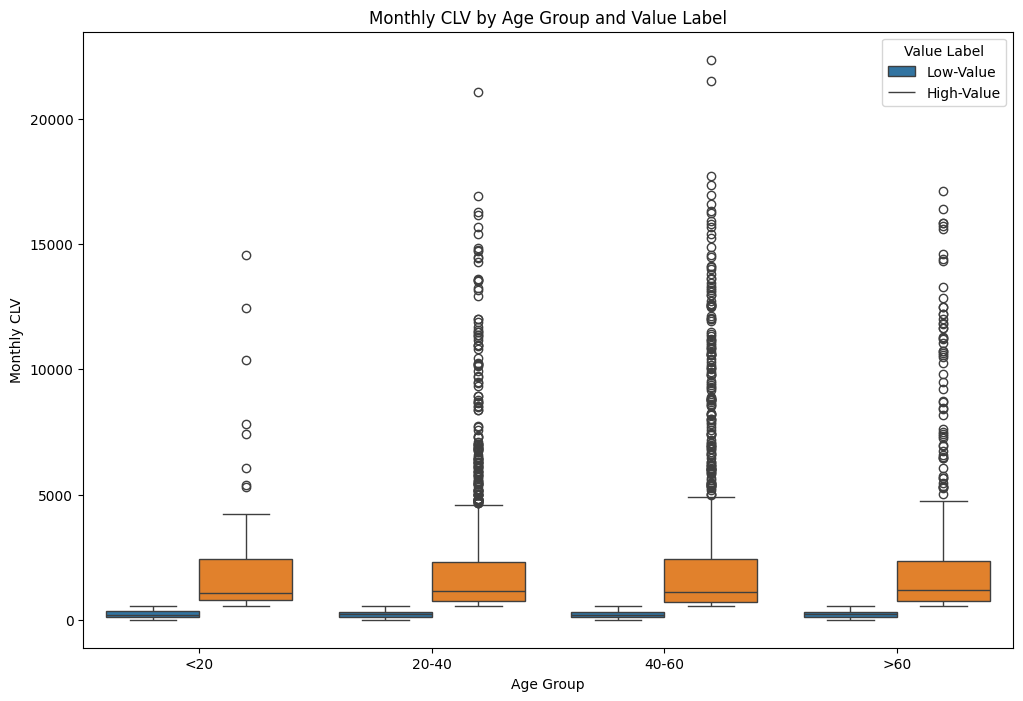

In [56]:
# age-clv analysis
# Define age groups
bins = [0, 20, 40, 60, np.inf]
labels = ['<20', '20-40', '40-60', '>60']
merged_df['age_group'] = pd.cut(merged_df['age'], bins=bins, labels=labels, right=False)

# Calculate median and mean of monthly CLV grouped by age and value label
age_clv_stats = merged_df.groupby(['age_group', 'value_label'])['clv_monthly'].agg(['median', 'mean']).reset_index()

print(age_clv_stats)

# Prepare data for boxplot
boxplot_data = merged_df[['age_group', 'value_label', 'clv_monthly']]

# Plotting
plt.figure(figsize=(12, 8))
sns.boxplot(x='age_group', y='clv_monthly', hue='value_label', data=boxplot_data)
plt.title('Monthly CLV by Age Group and Value Label')
plt.xlabel('Age Group')
plt.ylabel('Monthly CLV')
plt.legend(title='Value Label', labels=['Low-Value', 'High-Value'])
plt.show()

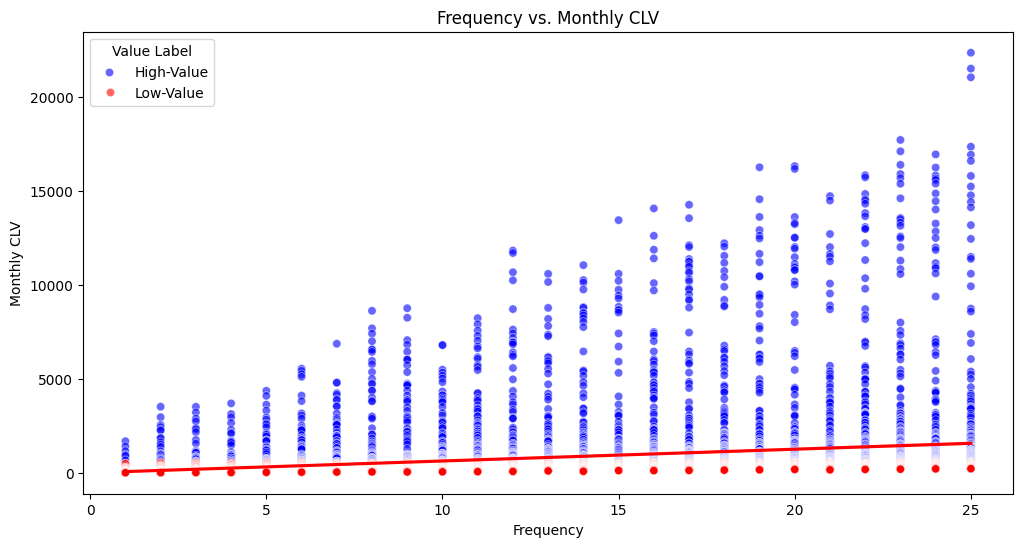

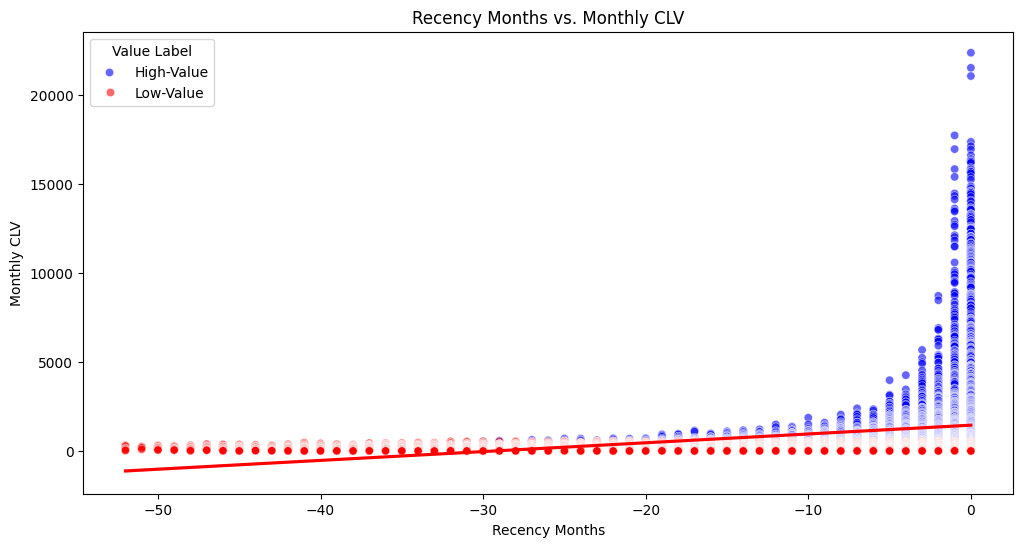

In [57]:
# Scatter plot: Frequency vs. Monthly CLV
plt.figure(figsize=(12, 6))
sns.scatterplot(data=merged_df, x='frequency', y='clv_monthly', hue='value_label', palette=['red', 'blue'], alpha=0.6)
sns.regplot(data=merged_df, x='frequency', y='clv_monthly', scatter=False, color='red')
plt.title('Frequency vs. Monthly CLV')
plt.xlabel('Frequency')
plt.ylabel('Monthly CLV')
plt.legend(title='Value Label', labels=['High-Value', 'Low-Value'])
plt.show()

# Scatter plot: Recency Months vs. Monthly CLV
plt.figure(figsize=(12, 6))
sns.scatterplot(data=merged_df, x='recency_months', y='clv_monthly', hue='value_label', palette=['red', 'blue'], alpha=0.6)
sns.regplot(data=merged_df, x='recency_months', y='clv_monthly', scatter=False, color='red')
plt.title('Recency Months vs. Monthly CLV')
plt.xlabel('Recency Months')
plt.ylabel('Monthly CLV')
plt.legend(title='Value Label', labels=['High-Value', 'Low-Value'])
plt.show()

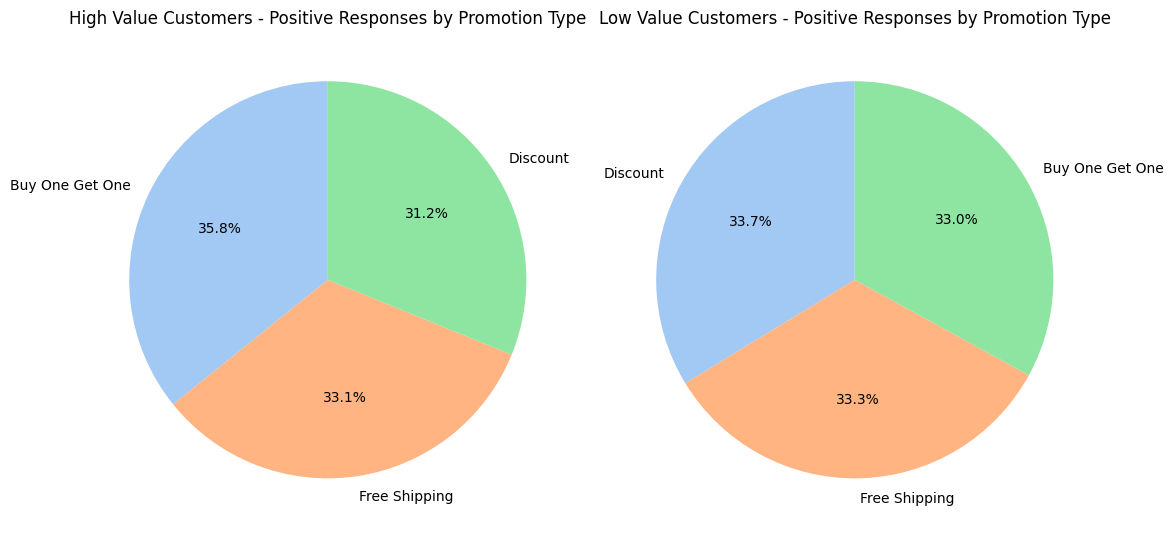

In [58]:
# EDA response type
# Filter high value and low value customers
high_value_customers = merged_df[merged_df['value_label'] == 1]['customer_id']
low_value_customers = merged_df[merged_df['value_label'] == 0]['customer_id']

# Filter marketing data for high value and low value customers
high_value_marketing = marketing_df[marketing_df['customer_id'].isin(high_value_customers) & (marketing_df['response'] == 'Yes')]
low_value_marketing = marketing_df[marketing_df['customer_id'].isin(low_value_customers) & (marketing_df['response'] == 'Yes')]

# Count positive responses for each promotion type
high_value_promotion_counts = high_value_marketing['promotion_type'].value_counts()
low_value_promotion_counts = low_value_marketing['promotion_type'].value_counts()

# Plot pie chart for high value customers
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
high_value_promotion_counts.plot.pie(autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
plt.title('High Value Customers - Positive Responses by Promotion Type')
plt.ylabel('')

# Plot pie chart for low value customers
plt.subplot(1, 2, 2)
low_value_promotion_counts.plot.pie(autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
plt.title('Low Value Customers - Positive Responses by Promotion Type')
plt.ylabel('')

plt.tight_layout()
plt.show()

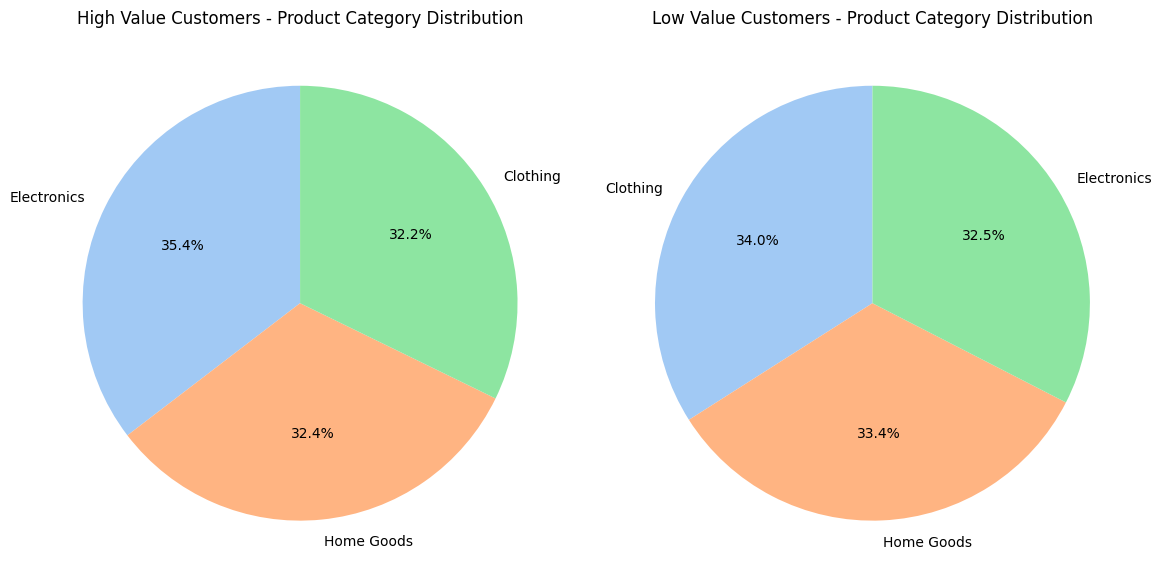

In [59]:
# Promotion type analysis
# Filter high value and low value customers
high_value_customers = merged_df[merged_df['value_label'] == 1]['customer_id']
low_value_customers = merged_df[merged_df['value_label'] == 0]['customer_id']

# Filter transaction data for high value and low value customers
high_value_transactions = transactions_df[transactions_df['customer_id'].isin(high_value_customers)]
low_value_transactions = transactions_df[transactions_df['customer_id'].isin(low_value_customers)]

# Count product categories for each customer group
high_value_product_counts = high_value_transactions['product_category'].value_counts()
low_value_product_counts = low_value_transactions['product_category'].value_counts()

# Plot pie chart for high value customers
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
high_value_product_counts.plot.pie(autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
plt.title('High Value Customers - Product Category Distribution')
plt.ylabel('')

# Plot pie chart for low value customers
plt.subplot(1, 2, 2)
low_value_product_counts.plot.pie(autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
plt.title('Low Value Customers - Product Category Distribution')
plt.ylabel('')

plt.tight_layout()
plt.show()

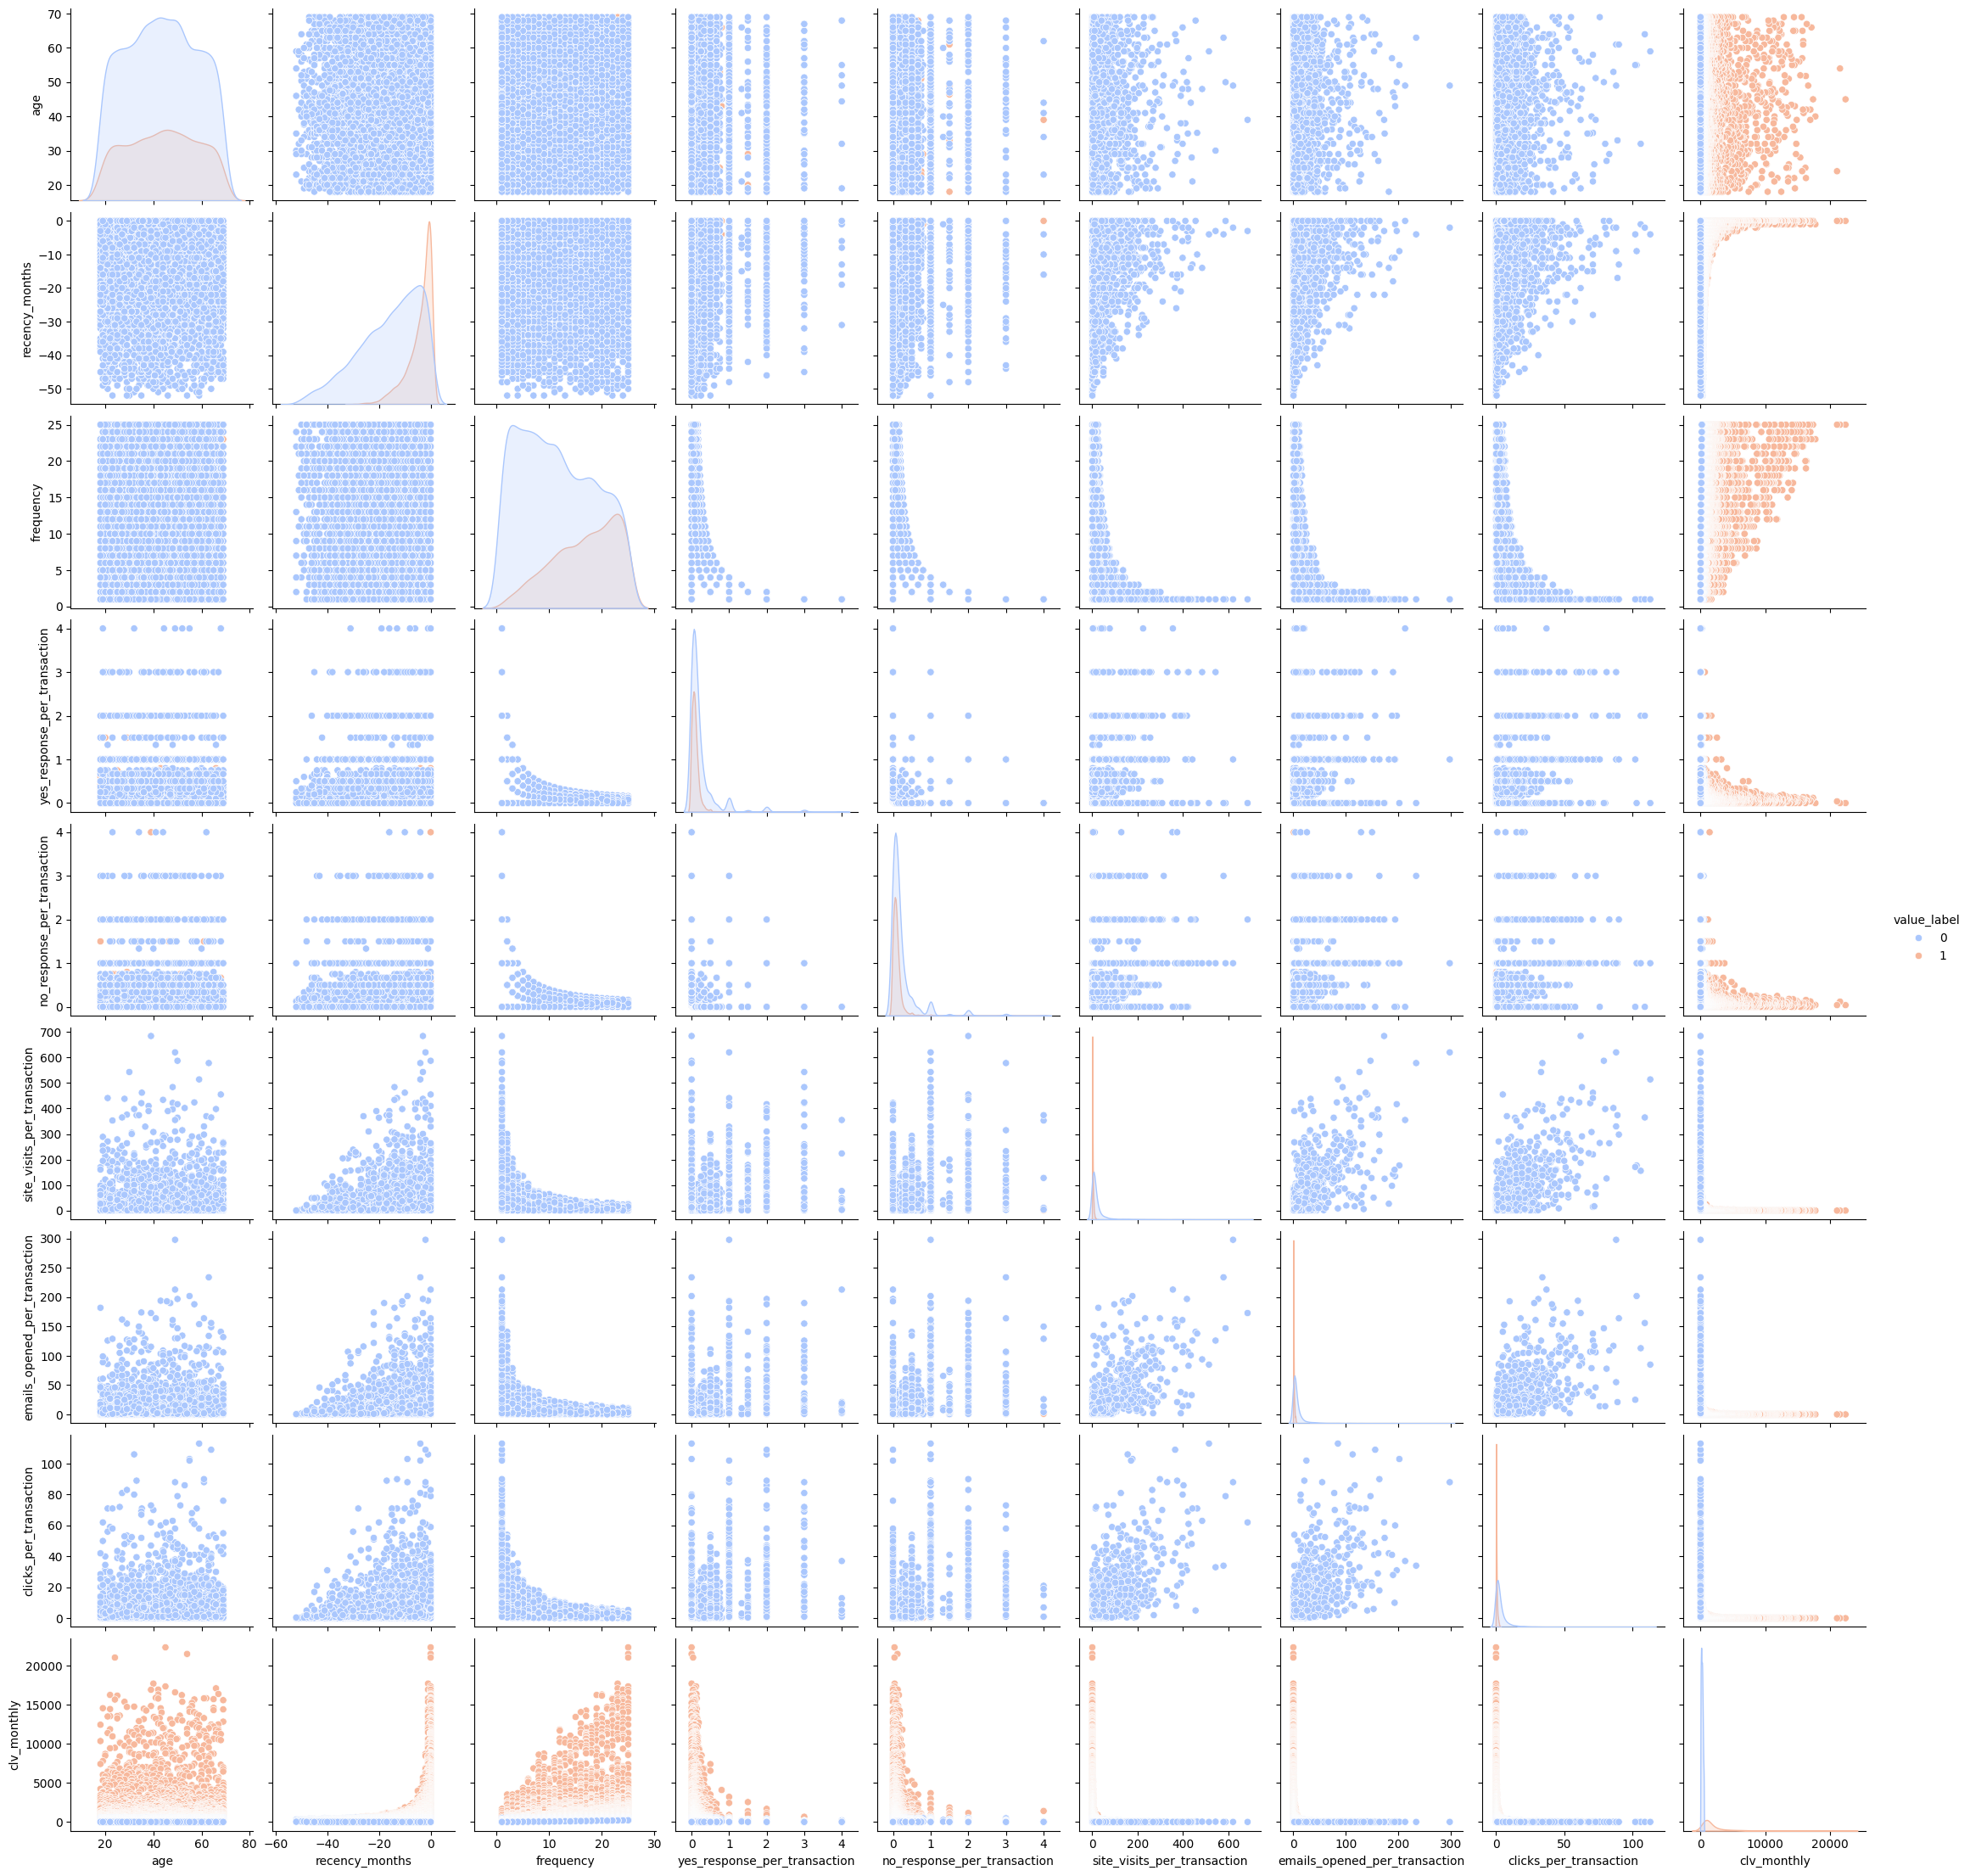

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt

# Include only numeric features and the target variable
numeric_features = ['age', 'recency_months', 'frequency', 'yes_response_per_transaction', 
                    'no_response_per_transaction', 'site_visits_per_transaction', 
                    'emails_opened_per_transaction', 'clicks_per_transaction', 'clv_monthly']

# Create a pairplot
sns.pairplot(merged_df, vars=numeric_features, hue='value_label', palette='coolwarm', diag_kind='kde')

# Display the plot
plt.show()

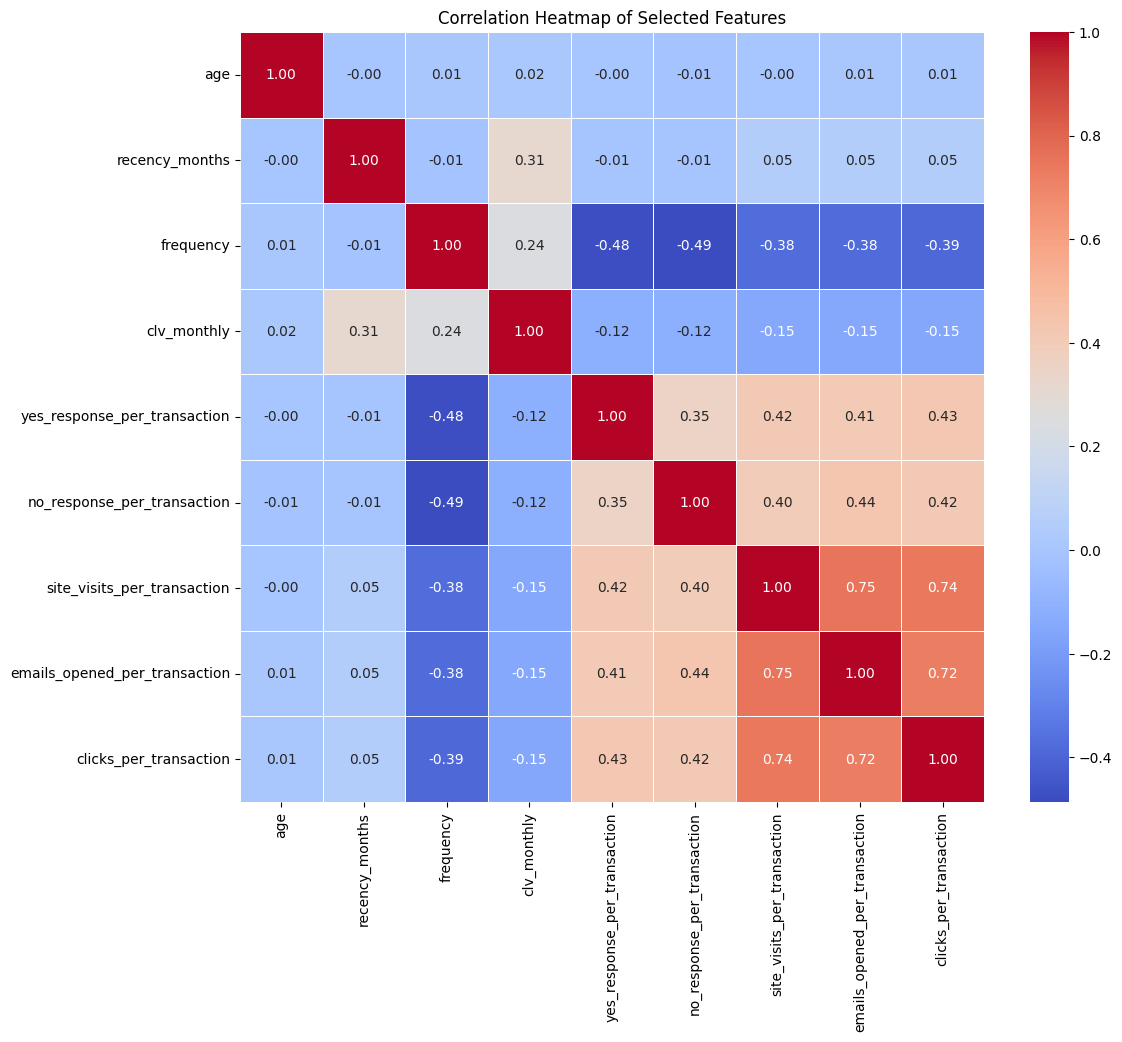

In [61]:
#run a py-plot
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your DataFrame is named 'merged_df'
# Include only numeric features and the target variable
numeric_features = ['age', 'recency_months', 'frequency', 'clv_monthly', 'yes_response_per_transaction', 
                    'no_response_per_transaction', 'site_visits_per_transaction', 
                    'emails_opened_per_transaction', 'clicks_per_transaction']

# Calculate the correlation matrix
corr_matrix = merged_df[numeric_features].corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Selected Features')
plt.show()


In [62]:
# Check the imbalance
# Calculate the distribution of the target variable
class_distribution = merged_df['value_label'].value_counts(normalize=True)

# Print the class distribution
print(class_distribution)

value_label
0    0.7265
1    0.2735
Name: proportion, dtype: float64


In [63]:
## Model

In [64]:
# split data into X variables and y variable
# Define the y variable
y = merged_df['value_label']

# Define the X variables
X = merged_df[['age', 'gender', 'recency_months', 'frequency', 'yes_response_per_transaction', 
               'no_response_per_transaction', 'site_visits_per_transaction', 
               'emails_opened_per_transaction', 'clicks_per_transaction']]

In [65]:
# scale the features using MinMaxScaler
# encode the categorical variables using OneHotEncoder
# split the data into training and testing sets
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

# Apply MinMaxScaler to X
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X[['age', 'recency_months', 'frequency', 'yes_response_per_transaction',
                                   'no_response_per_transaction', 'site_visits_per_transaction',
                                   'emails_opened_per_transaction', 'clicks_per_transaction']])

# Encode the gender column in X
encoder = OneHotEncoder(drop='first')
gender_encoded = encoder.fit_transform(X[['gender']]).toarray()

# Concatenate scaled numerical features and encoded categorical features
X_encoded = np.hstack((X_scaled, gender_encoded))

# Split the data into training and testing sets, reserving 30% for testing
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.30, random_state=42)


In [66]:
# Create Pipelines and check the F1 socre for each model
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

# Define numeric and categorical columns
numeric_columns = ['age', 'recency_months', 'frequency', 'yes_response_per_transaction', 
                   'no_response_per_transaction', 'site_visits_per_transaction', 
                   'emails_opened_per_transaction', 'clicks_per_transaction']
categorical_columns = ['gender']

# Create a pre-processing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numeric_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
    ]
)

# Define the models
knn = KNeighborsClassifier()
logreg = LogisticRegression()
nb = GaussianNB()

# Split the data into training and testing sets, reserving 30% for testing
X = merged_df[numeric_columns + categorical_columns]
y = merged_df['value_label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# Create pipelines for each model
knn_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', knn)])
logreg_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', logreg)])
nb_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', nb)])

# Evaluate the models using cross-validation
knn_scores = cross_val_score(knn_pipeline, X_train, y_train, scoring='f1', cv=5)
logreg_scores = cross_val_score(logreg_pipeline, X_train, y_train, scoring='f1', cv=5)
nb_scores = cross_val_score(nb_pipeline, X_train, y_train, scoring='f1', cv=5)

# Print the cross-validation scores
print(f'KNN_scores:{np.mean(knn_scores)}')
print(f'logreg_scores:{np.mean(logreg_scores)}')
print(f'nb_scores:{np.mean(nb_scores)}')

KNN_scores:0.6833256798777866
logreg_scores:0.7019117172578134
nb_scores:0.7227458972372964


In [67]:
# Improve KNN Model
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for KNN
param_grid = {
    'classifier__n_neighbors': [5, 7, 9, 11, 15, 35, 45, 55],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__metric': ['euclidean', 'manhattan', 'minkowski']
}

# Create the pipeline for KNN
knn_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', KNeighborsClassifier())])

# Create the GridSearchCV object
grid_search = GridSearchCV(knn_pipeline, param_grid, cv=5, scoring='f1',verbose=1)

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

print(f'KNN-Best Parameters: {best_params}')

Fitting 5 folds for each of 48 candidates, totalling 240 fits
KNN-Best Parameters: {'classifier__metric': 'manhattan', 'classifier__n_neighbors': 15, 'classifier__weights': 'distance'}


In [68]:
# final pipeline
#final_classifier
final_classifier = KNeighborsClassifier(n_neighbors=grid_search.best_params_['classifier__n_neighbors'],
                                        metric = grid_search.best_params_['classifier__metric'],
                                        weights = grid_search.best_params_['classifier__weights']
                                        )

#final_pipeline
final_pipeline = Pipeline(steps=
                          [
                              ('preprocessor',preprocessor),
                              ('classifier',final_classifier)
                          ])

# fit the data
final_pipeline.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  ['age', 'recency_months',
                                                   'frequency',
                                                   'yes_response_per_transaction',
                                                   'no_response_per_transaction',
                                                   'site_visits_per_transaction',
                                                   'emails_opened_per_transaction',
                                                   'clicks_per_transaction']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['gender'])])),
                ('classifier',
                 KNeighborsClassifier(metric='manhattan', n_neighbors=15,
                                      weights='distance'))])

Accuracy: 0.8683
Precision: 0.7352
Recall: 0.8272
F1 Score: 0.7785
ROC AUC Score: 0.9372
              precision    recall  f1-score   support

   Low-Value       0.93      0.88      0.91      2161
  High-Value       0.74      0.83      0.78       839

    accuracy                           0.87      3000
   macro avg       0.83      0.86      0.84      3000
weighted avg       0.88      0.87      0.87      3000



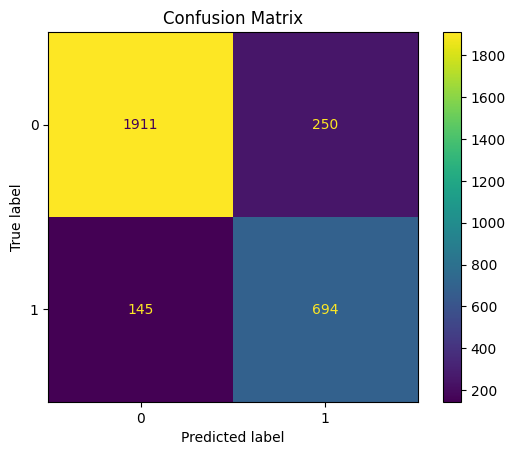

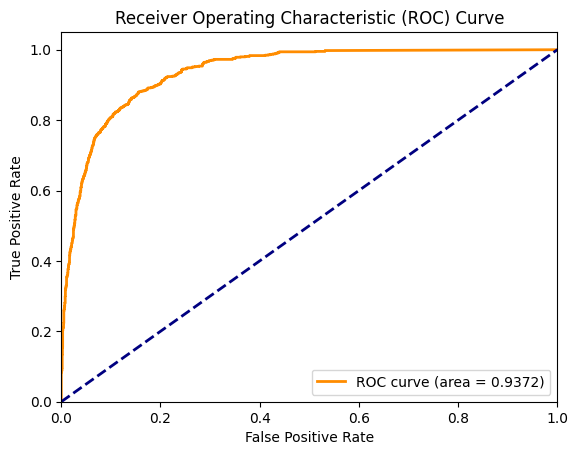

In [69]:
#make predictions with KNN model on the test set
#evaluate the KNN model using accuracy, precision, recall, F1 score, and ROC AUC score
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, average_precision_score, roc_auc_score, roc_curve, classification_report

# Make predictions on the test set
y_pred = final_pipeline.predict(X_test)
y_pred_proba = final_pipeline.predict_proba(X_test)[:, 1] 

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label=1)
recall = recall_score(y_test, y_pred, pos_label=1)
f1 = f1_score(y_test, y_pred, pos_label=1)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Print evaluation metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'ROC AUC Score: {roc_auc:.4f}')

# Detailed classification report
print(classification_report(y_test, y_pred, target_names=['Low-Value', 'High-Value']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
cmd = ConfusionMatrixDisplay(cm, display_labels=[0, 1])
cmd.plot()
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba, pos_label=1)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()



In [70]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import statsmodels.api as sm

# Assuming X and y are already defined as the feature matrix and target variable
# Apply MinMaxScaler to X
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X[['age', 'recency_months', 'frequency', 'yes_response_per_transaction',
                                   'no_response_per_transaction', 'site_visits_per_transaction',
                                   'emails_opened_per_transaction', 'clicks_per_transaction']])

# Encode the gender column in X
encoder = OneHotEncoder(drop='first', sparse_output=False)
gender_encoded = encoder.fit_transform(X[['gender']])

# Concatenate scaled numerical features and encoded categorical features
X_encoded = np.hstack((X_scaled, gender_encoded))

# Split the data into training and testing sets, reserving 30% for testing
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.30, random_state=42)

# Create a DataFrame for statsmodels' logit function
# Assuming column names are provided for both scaled and encoded features
scaled_feature_names = ['age', 'recency_months', 'frequency', 'yes_response_per_transaction',
                        'no_response_per_transaction', 'site_visits_per_transaction',
                        'emails_opened_per_transaction', 'clicks_per_transaction']
encoded_feature_names = encoder.get_feature_names_out(['gender']).tolist()
all_feature_names = scaled_feature_names + encoded_feature_names

train_data = pd.DataFrame(X_train, columns=all_feature_names)
train_data['value_label'] = y_train.values

# Create the formula for the logit model
formula = 'value_label ~ ' + ' + '.join(all_feature_names)
model = sm.Logit.from_formula(formula=formula, data=train_data).fit()

# Print coefficients and p-values
print("Coefficients and p-values for each feature:")
coef_pvalues = pd.DataFrame({
    'Coefficient': model.params,
    'P-value': model.pvalues
})
print(coef_pvalues)

# Make predictions on the test set using sklearn's LogisticRegression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred_prob = log_reg.predict_proba(X_test)[:, 1]
y_pred = log_reg.predict(X_test)

# Evaluate the model on the test set
test_accuracy = accuracy_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred)
test_roc_auc = roc_auc_score(y_test, y_pred_prob)

print(f"Test Set Performance:")
print(f"Accuracy: {test_accuracy}")
print(f"Precision: {test_precision}")
print(f"Recall: {test_recall}")
print(f"F1 Score: {test_f1}")
print(f"ROC AUC Score: {test_roc_auc}")

# Display the model summary
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.168527
         Iterations 11
Coefficients and p-values for each feature:
                               Coefficient        P-value
Intercept                       -13.952631  2.266569e-146
age                               0.158340   3.931662e-01
recency_months                   16.468405  7.027193e-187
frequency                         4.042884   5.235914e-54
yes_response_per_transaction     -0.322298   7.830921e-01
no_response_per_transaction      -0.335817   7.470800e-01
site_visits_per_transaction    -142.689224   7.219980e-42
emails_opened_per_transaction  -169.934246   7.684662e-47
clicks_per_transaction         -127.138306   1.254012e-44
gender_Male                      -0.057066   5.978288e-01
gender_Unknown                    0.031535   8.942826e-01
Test Set Performance:
Accuracy: 0.8623333333333333
Precision: 0.7824933687002652
Recall: 0.7032181168057211
F1 Score: 0.7407407407407407
ROC AUC Score: 0.937